# Smartphone Price Prediction Analysis

This notebook covers the exploratory data analysis (EDA), data cleaning, model training, and evaluation for the Smartphone Price Prediction project.

## 1. Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

## 2. Load Data

In [11]:
df = pd.read_csv('../data/smartphones.csv')
df.head()

,smartphone_brand,model,price_inr,rating_score,processor_name,processor_brand,core_count,clock_speed_ghz,ram_gb,storage_gb,...,battery_mah,fast_charging,charging_watt,rear_camera_count,front_camera_count,rear_camera_main_mp,front_camera_main_mp,os_name,memory_card_supported,memory_card_type
0,blackzone,BlackZone S25 Ultra Maxx,8999,63,unisoc sc9863a1,unisoc,8,1.6,8,128,...,5000,False,10.0,1,1,32.0,16.0,android,NaN,NaN
1,ringme,Ringme Bold P70,5800,44,mediatek helio,mediatek,2,1.3,4,128,...,3260,False,10.0,1,0,13.0,NaN,android,NaN,NaN
2,lava,Lava Shark 5G (4GB RAM + 128GB),8998,60,unisoc t765,unisoc,8,2.3,4,128,...,5000,True,10.0,1,1,13.0,5.0,android,True,dedicated
3,vivo,Vivo Y19s 5G (4GB RAM + 128GB),11999,69,mediatek dimensity 6300,mediatek,8,2.4,4,128,...,6000,True,15.0,2,1,13.0,5.0,android,True,dedicated
4,vivo,Vivo Y19s 5G (4GB RAM + 64GB),10999,68,mediatek dimensity 6300,mediatek,8,2.4,4,64,...,6000,True,15.0,2,1,13.0,5.0,android,True,dedicated


## 3. Data Cleaning & Preprocessing
- Fill missing values (Median for Numerical, Mode for Categorical)
- Remove outliers using IQR on 'price_inr'

In [12]:
# Handling Missing Values
num_cols = ['ram_gb', 'storage_gb', 'battery_mah', 'rear_camera_main_mp', 'display_inches']
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

cat_cols = ['smartphone_brand', 'processor_brand']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Outlier Removal (Price)
Q1 = df['price_inr'].quantile(0.25)
Q3 = df['price_inr'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df[(df['price_inr'] >= (Q1 - 1.5 * IQR)) & (df['price_inr'] <= (Q3 + 1.5 * IQR))].copy()

print(f"Original shape: {df.shape}, Cleaned shape: {df_clean.shape}")

Original shape: (758, 27), Cleaned shape: (678, 27)


## 4. Visualizations
### Price Distribution

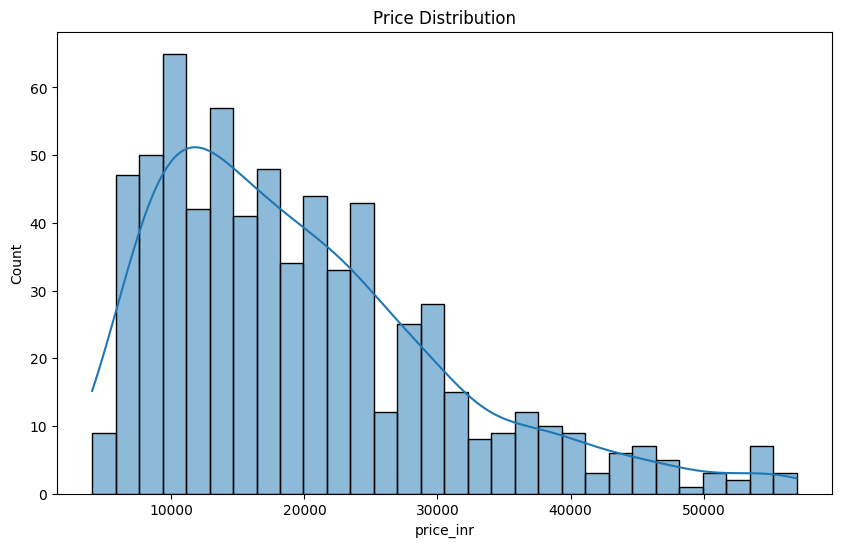

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price_inr'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

### Correlation Heatmap

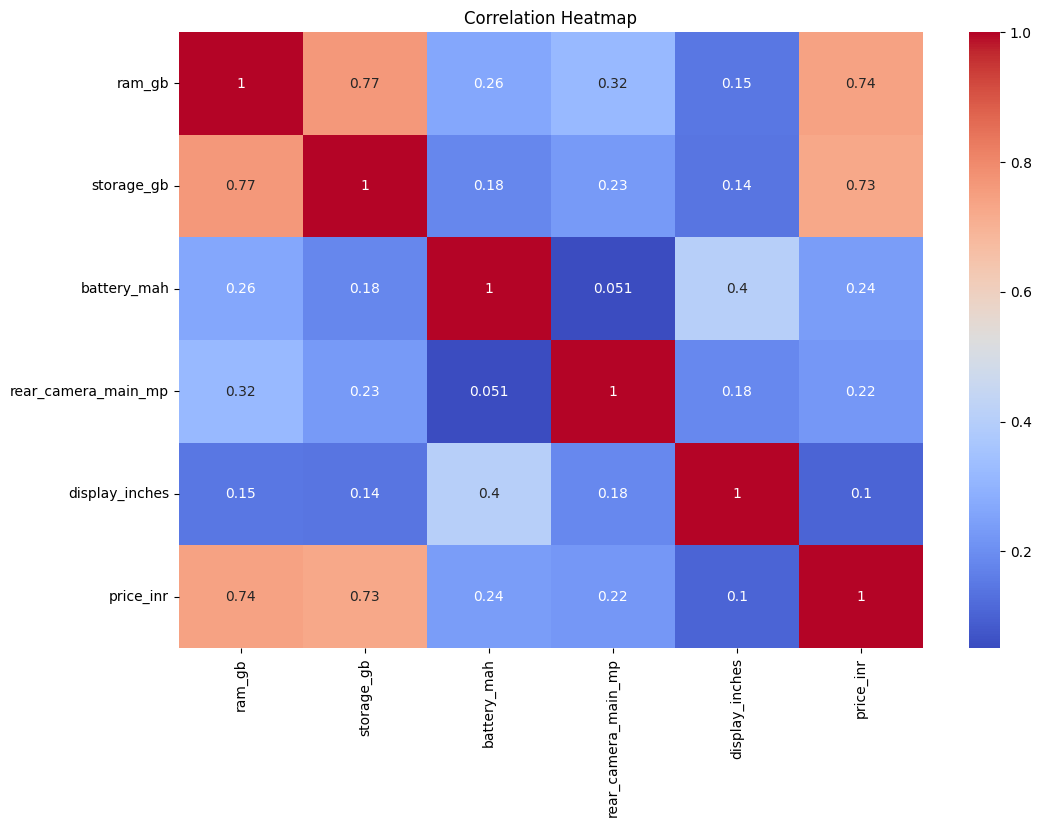

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[num_cols + ['price_inr']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 5. Model Training
We will train Linear Regression and Random Forest Regressor.

In [15]:
X = df_clean[['smartphone_brand', 'ram_gb', 'storage_gb', 'battery_mah', 'rear_camera_main_mp', 'display_inches', 'processor_brand']]
y = df_clean['price_inr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['ram_gb', 'storage_gb', 'battery_mah', 'rear_camera_main_mp', 'display_inches']
categorical_features = ['smartphone_brand', 'processor_brand']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'y_pred': y_pred}
    
    print(f"{name}:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


Linear Regression:
MAE: 4053.88, RMSE: 6645.66, R2: 0.6540
Random Forest:
MAE: 3720.58, RMSE: 5663.26, R2: 0.7487


## 6. Evaluation Plots
### Actual vs Predicted (Random Forest)

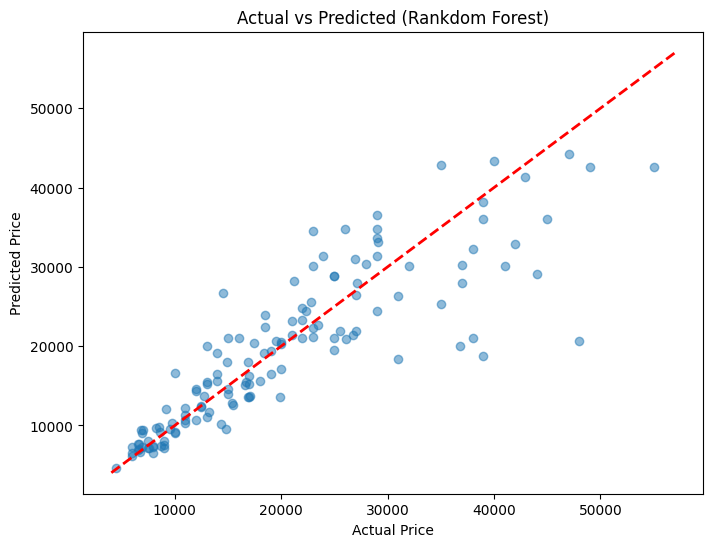

In [16]:
rf_preds = results['Random Forest']['y_pred']
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Rankdom Forest)')
plt.show()

### Feature Importance

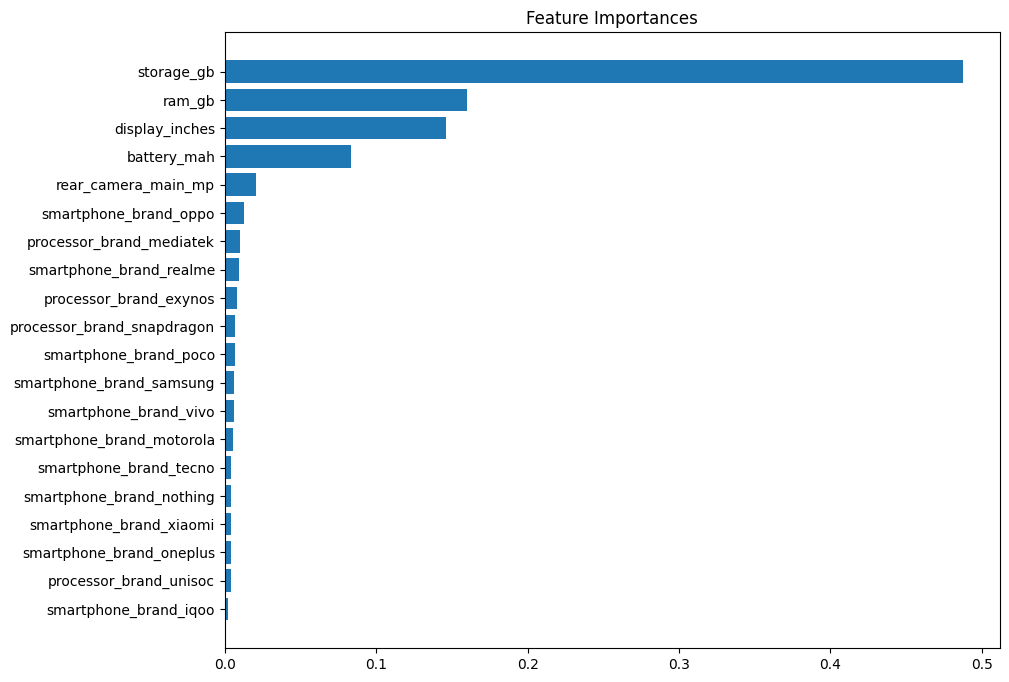

In [17]:
# Extract feature importance from RF pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', models['Random Forest'])])
rf_pipeline.fit(X_train, y_train)

rf_model = rf_pipeline.named_steps['regressor']
preprocessor_step = rf_pipeline.named_steps['preprocessor']

cat_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.r_[numeric_features, cat_names]

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(top_n), importances[indices[:top_n]], align="center")
plt.yticks(range(top_n), feature_names[indices[:top_n]])
plt.gca().invert_yaxis()
plt.show()

In [21]:
import joblib
import os
import numpy as np

model_path = r"D:\price-prediction-project\models\best_model.pkl"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

model = joblib.load(model_path)
print("Model loaded successfully")


Model loaded successfully


In [25]:
import joblib
import pandas as pd

# Load model
model = joblib.load(r"D:\price-prediction-project\models\best_model.pkl")

print("\nSMARTPHONE PRICE PREDICTION\n")

print("Smartphone Brand Encoding:")
print("0 = Apple")
print("1 = Samsung")
print("2 = Xiaomi")
print("3 = Realme")
print("4 = OnePlus")
print("5 = Vivo")
print("6 = Oppo")
print("7 = Motorola")
print("8 = Nokia")
print("9 = Others\n")

print("Processor Brand Encoding:")
print("0 = Snapdragon")
print("1 = MediaTek")
print("2 = Exynos")
print("3 = Apple Bionic")
print("4 = Unisoc")
print("5 = Others\n")

# User inputs
smartphone_brand = int(input("Enter Smartphone Brand Code: "))
ram_gb = int(input("Enter RAM (GB): "))
storage_gb = int(input("Enter Storage (GB): "))
battery_mah = int(input("Enter Battery Capacity (mAh): "))
rear_camera_main_mp = int(input("Enter Rear Camera (MP): "))
display_inches = float(input("Enter Display Size (in inches): "))
processor_brand = int(input("Enter Processor Brand Code: "))

# Create DataFrame with EXACT column names
input_df = pd.DataFrame([{
    "smartphone_brand": smartphone_brand,
    "ram_gb": ram_gb,
    "storage_gb": storage_gb,
    "battery_mah": battery_mah,
    "rear_camera_main_mp": rear_camera_main_mp,
    "display_inches": display_inches,
    "processor_brand": processor_brand
}])

# Prediction
predicted_price = model.predict(input_df)[0]

print(f"\nPredicted Smartphone Price: ₹{round(predicted_price, 2)}")



SMARTPHONE PRICE PREDICTION

Smartphone Brand Encoding:
0 = Apple
1 = Samsung
2 = Xiaomi
3 = Realme
4 = OnePlus
5 = Vivo
6 = Oppo
7 = Motorola
8 = Nokia
9 = Others

Processor Brand Encoding:
0 = Snapdragon
1 = MediaTek
2 = Exynos
3 = Apple Bionic
4 = Unisoc
5 = Others


Predicted Smartphone Price: ₹47960.65
